# `Model` API: Quick start guide

> **tldr:** This notebook is a quick-start guide to the NeuralGCM Model API, which is designed for model developers and built on `nnx` and `coordax`. You will learn how to define a model by subclassing `api.Model` and implementing the core `assimilate`, `advance`, and `observe` methods. The guide explains how models manage their own state (e.g., `Prognostic` variables) and how this state is partitioned using a typing system. This partitioning is essential for applying JAX transformations like `nnx.scan` (demonstrated in an `unroll_model` example) and `jax.grad`. Finally, it covers how `ObservationOperator` modules are used to compute and extract data from the model state in response to a user query.

`Model` API is designed for model developers and aims to facilitate:
* Training
* Composition and coupling of model components
* Inspection and model surgery

Readers unfamiliar with [`coordax`](https://coordax.readthedocs.io/en/latest/) or [`nnx`](https://flax.readthedocs.io/en/v0.8.3/experimental/nnx/index.html) are encouraged to review the respective tutorials before proceeding with this notebook.

Outline:
1. Defining a model
2. Understanding model state and running simulations
3. Observation operators and model queries



In [5]:
import dataclasses
from functools import partial
from typing import Callable

from flax import nnx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import graphviz

import jax_datetime as jdt
import coordax as cx
from neuralgcm.experimental.core import api
from neuralgcm.experimental.core import coordinates
from neuralgcm.experimental.core import observation_operators
from neuralgcm.experimental.core import nnx_compat
from neuralgcm.experimental.core import time_integrators
from neuralgcm.experimental.core import parallelism
from neuralgcm.experimental.core import transforms
from neuralgcm.experimental.core import spherical_transforms
from neuralgcm.experimental.core import typing
from neuralgcm.experimental.core import module_utils


# small formatting improvements
import contextlib
np.set_printoptions(threshold=100)

@contextlib.contextmanager
def print_error():
  try:
    yield
  except Exception as e:
    print(f'{type(e).__name__}: {e}')


import logging
import warnings
warnings.simplefilter('ignore')
logging.getLogger('jax._src.lib.xla_bridge').addFilter(lambda _: False)

## Defining a model

**Key concepts:**
* A model is defined by implementing `assimilate`, `advance` and `observe` methods plus a `timestep` property
* The state of NeuralGCM models is stored in different `nnx.Variable` subtypes
* `Model` objects are instances of `nnx.Module`

Defining a `Model` requires implementing core methods for the following functions:
1. `assimimilate(inputs)` - assimilates inputs into a model state
2. `advance()` - advances model state by a `timestep`
3. `observe(query)` - computes observations for user `query`
4. `timestep` - model property indicating the size of a model timestep

### Lorenz-96 demo
As a working example we will implement variations of a Lorenz-96 dynamical system. The two-scale model extends includes slow and fast variables that couple to one another, described by a system of ODEs:

$$
\frac{dX_k}{dt} &= -X_{k-1}(X_{k-2} - X_{k+1}) - X_k + F - \frac{hc}{b} \sum_{j=1}^{J} Y_{j,k} \\
\frac{dY_{j,k}}{dt} &= -cbY_{j+1,k}(Y_{j+2,k} - Y_{j-1,k}) - cY_{j,k} + \frac{hc}{b} X_k
$$

Here $h, c, b$ are coupling parameters. The term $B_k(Y) = \frac{hc}{b} \sum_{j=1}^{J} Y_{j,k}$ represents the feedback from fast scales to slow scales.

In [6]:
# Definition of the Full Lorenz96

IntegratorCls = Callable[[time_integrators.ExplicitODE, float], nnx.Module]


def lorenz96_x_term(x: jax.Array, f: float) -> jax.Array:
  """Computes uncoupled term for `X` variables in L96 system."""
  x_p1 = jnp.roll(x, -1)
  x_m1 = jnp.roll(x, 1)
  x_m2 = jnp.roll(x, 2)
  return -x_m1 * (x_m2 - x_p1) - x + f


def lorenz96_y_term(y: jax.Array, c: float, b: float) -> jax.Array:
  """Computes uncoupled term for `Y` variables in L96 system."""
  y_p1 = jnp.roll(y, -1)
  y_p2 = jnp.roll(y, -2)
  y_m1 = jnp.roll(y, 1)
  return -(c * b) * y_p1 * (y_p2 - y_m1) - c * y


@nnx_compat.dataclass
class Lorenz96(api.Model):
  """Two timescale Lorenz-96 model."""
  k_axis: cx.Coordinate
  j_axis: cx.Coordinate
  forcing: float | nnx.Param = 10.0
  c: float | nnx.Param = 10.0
  b: float | nnx.Param = 10.0
  h: float | nnx.Param = 1.0
  time_integrator_cls: IntegratorCls = time_integrators.RungeKutta4
  dt: float = 0.002  # float integration time step for the Lorenz system.
  operators: dict[  # additional observation operators that will be discussed.
      str, observation_operators.ObservationOperator
  ] = dataclasses.field(default_factory=dict)
  # Prognostic fields initialized in __post_init__
  x: typing.Prognostic = dataclasses.field(init=False)
  y: typing.Prognostic = dataclasses.field(init=False)
  time: typing.Prognostic = dataclasses.field(init=False)

  def __post_init__(self):
    ks, js = self.k_axis, self.j_axis
    kjs = cx.compose_coordinates(ks, js)
    self.x = typing.Prognostic(cx.wrap(jnp.zeros(ks.shape), ks))
    self.y = typing.Prognostic(cx.wrap(jnp.zeros(kjs.shape), kjs))
    self.time = typing.Prognostic(cx.wrap(jdt.Datetime(jdt.Timedelta())))

  @property
  def xy_prognostics(self):
    return {'x': self.x.value, 'y': self.y.value}

  @property
  def prognostics(self):
    return self.xy_prognostics | {'time': self.time.value}

  @module_utils.ensure_unchanged_state_structure
  def assimilate(self, inputs: dict[str, dict[str, cx.Field]]) -> None:
    slice_last_time = lambda f: cx.cmap(lambda a: a[-1])(f.untag('timedelta'))
    self.x.value = slice_last_time(inputs['slow']['x'])
    self.y.value = slice_last_time(inputs['fast']['y'])
    self.time.value = slice_last_time(inputs['slow']['time'])

  @module_utils.ensure_unchanged_state_structure
  def advance(self) -> None:
    k, j = self.k_axis, self.j_axis
    f, c, b, h = self.forcing, self.c, self.b, self.h
    x_out_axes = {k: v for k, v in self.x.named_axes.items() if k != 'k'}
    y_out_axes = {k: v for k, v in self.y.named_axes.items() if k != 'j'}
    x_dot_fn = cx.cmap(partial(lorenz96_x_term, f=f), out_axes=x_out_axes)
    y_dot_fn = cx.cmap(partial(lorenz96_y_term, b=b, c=c), out_axes=y_out_axes)
    sum_fn = cx.cmap(jnp.sum)
    # Equation for coupled X and Y variables.
    all_terms_fn = lambda s: {
        'x': x_dot_fn(s['x'].untag(k)).tag(k) - (h*c/b)*sum_fn(s['y'].untag(j)),
        'y': y_dot_fn(s['y'].untag(j)).tag(j) + (h*c/b) * s['x'],
    }
    full_ode = time_integrators.ExplicitODE.from_functions(all_terms_fn)
    next_xy = self.time_integrator_cls(full_ode, self.dt)(self.xy_prognostics)
    self.x.value = next_xy['x']
    self.y.value = next_xy['y']
    self.time.value += self.timestep  # treated separately to avoid round off.

  @module_utils.ensure_unchanged_state_structure
  def observe(
      self,
      query: dict[str, dict[str, cx.Field | cx.Coordinate]],
  ) -> dict[str, dict[str, cx.Field]]:
    fixed_operators = {
        'slow': observation_operators.DataObservationOperator({'x': self.x.value}),
        'fast': observation_operators.DataObservationOperator({'y': self.y.value}),
    }
    result = {}
    all_operators = fixed_operators | self.operators
    for k, q in query.items():
      if k in all_operators:
        result[k] = all_operators[k].observe(self.prognostics, q)
    return result

  @property
  def timestep(self) -> np.timedelta64:
    # Lorenz96 non dimensional time roughly corresponds to 120h.
    return np.timedelta64(int(self.dt * 120), 'h')

Defining the model above included three main steps:

1. Creation of `typing.Prognostic` variables (`self.x`, `self.y` and `self.time`) at initialization
2. Implementation of core methods `assimilate`, `advance`, `observe`, `timedelta`
3. Adding the optional `ensure_unchanged_state_structure` decorator, which verifies that these methods do not change the state's structure

Now we can instantiate and play with this model. We will look into some implementation details shortly


In [7]:
# Instantiating coordinates and Lorenz96 model.
k = cx.LabeledAxis('k', np.arange(36))
j = cx.LabeledAxis('j', np.arange(8))

l96_model = Lorenz96(k, j)

nnx.display(l96_model)  # inspecting model using treescope.

In [8]:
# simulation state variables are currently initialized to 0.
nnx.display(l96_model.x)

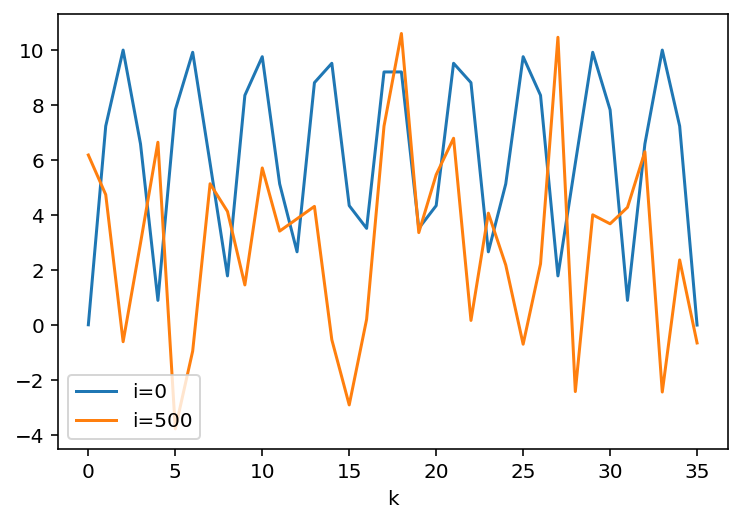

In [16]:
# Using models' core methods.

fig, ax = plt.subplots()  # will be used to plot X_k state.

# Preparing inputs for model initialization
kj = cx.compose_coordinates(k, j)
rng = np.random.RandomState(0)
x_init = abs(10 * np.sin(np.linspace(0, 13 * 2*np.pi, k.sizes['k'])))
x_init[0] += 0.01
t0 = jdt.Datetime.from_isoformat('2000-01-01')
inputs = {
    'slow': {'x': cx.wrap(x_init, k), 'time': cx.wrap(t0)},
    'fast': {'y': cx.wrap(rng.uniform(size=kj.shape, low=-0.5, high=0.5), kj)},
}
# assimilate expects at least a dummy timedelta dimension, we add it here.
t_del = coordinates.TimeDelta(np.zeros(1) * np.timedelta64(1, 'h'))
add_td = lambda f: f.broadcast_like(cx.compose_coordinates(t_del, f.coordinate))
inputs = jax.tree.map(add_td, inputs, is_leaf=cx.is_field)

# Assimilate updates the simulation state in place using inputs.
l96_model.assimilate(inputs)

# Observe lets the user to "query" the simulation state.
observations = l96_model.observe({'slow': {'x': k}})  # observe X.
observations['slow']['x'].to_xarray().plot(x='k', ax=ax, label='i=0')  # plot X.

# Advance updates the simulation state in place.
for _ in range(500):
  l96_model.advance()

observations = l96_model.observe({'slow': {'x': k}})  # observe evolved state.
observations['slow']['x'].to_xarray().plot(x='k', ax=ax, label='i=500')
plt.legend()

Notice how the system's state "lives" on the `Model` instance and is updated when
we call methods such as `assimilate`, `advance`.

We can see the effect of that in the example above by noticings that the prognostics variables `model.x` has changed:

In [18]:
nnx.display(l96_model.x)

This choice offers several advantages:
* No need to explicitly wire the simulation state between calls
* Simulation state can be automatically extracted using `nnx.state`

This also implies certain sharp edges:
* Execution order matters, as the model is mutable, examples include:
  * Changing parameter by assignment: `l96_coarse_model.forcing.value = 0`
  * Running model methods like advance, assimilate,

## Understanding model state

**Key concepts:**
* Typing system allows partitioning of the model state (simulation, fixed params, trainable params, etc)
* Model state partitioning is crucial for transformations like `scan`, `vmap`, `grad`
* `Model` can be easily vectorized if simulation state variables wrap `cx.Field` instances

`Model` instance can hold a variety of stateful parameters of different `nnx.Variable` subtypes.

Below are the most common types showing their hierarchical relationships:


Installing Graphviz MPM in /export/hda3/borglet/remote_hdd_fs_dirs/0.colab.whirl_dkochkov_oe.kernel.dkochkov.1275925275639.14b334fb3717c109/mount/logs.0.colab.whirl_dkochkov_oe.kernel.dkochkov.1275925275639/tmp/tmp5wua_jrz_dot/graphviz
Installed package tools/graphviz version live at /export/hda3/borglet/remote_hdd_fs_dirs/0.colab.whirl_dkochkov_oe.kernel.dkochkov.1275925275639.14b334fb3717c109/mount/logs.0.colab.whirl_dkochkov_oe.kernel.dkochkov.1275925275639/tmp/tmp5wua_jrz_dot/graphviz.
Installing X11 Fonts MPM in /export/hda3/borglet/remote_hdd_fs_dirs/0.colab.whirl_dkochkov_oe.kernel.dkochkov.1275925275639.14b334fb3717c109/mount/logs.0.colab.whirl_dkochkov_oe.kernel.dkochkov.1275925275639/tmp/tmp5wua_jrz_dot/x11_fonts
Installed package visualization/graphviz_server/x11_fonts version live at /export/hda3/borglet/remote_hdd_fs_dirs/0.colab.whirl_dkochkov_oe.kernel.dkochkov.1275925275639.14b334fb3717c109/mount/logs.0.colab.whirl_dkochkov_oe.kernel.dkochkov.1275925275639/tmp/tmp5wua_j

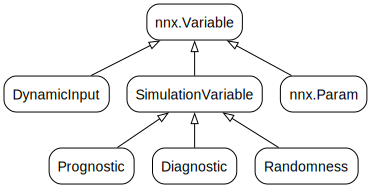

In [ ]:
#@title types hierarchy graphviz
dot_source = """
digraph {
  rankdir=BT
  node [shape=box, style=rounded, fontname="Arial"]
  edge [arrowhead=empty]

  Variable [label="nnx.Variable"]
  DynamicInput
  SimulationVariable
  Prognostic
  Diagnostic
  Randomness
  Param [label="nnx.Param"]

  Prognostic -> SimulationVariable
  Diagnostic -> SimulationVariable
  Randomness -> SimulationVariable
  SimulationVariable -> Variable
  DynamicInput -> Variable
  Param -> Variable
}
"""

# Render the graph in Colab
graph = graphviz.Source(dot_source)
graph

We can extract slices of model state using `nnx.state` using specific types, groups of types or `nnx.filterlib.Filter`.

In [19]:
l96_model.h = nnx.Param(1.0)  # make `h` a dummy trainable parameter.

In [20]:
nnx.state(l96_model, nnx.Variable)  # all stateful Variable, includes `h`.

State({
  'h': Param(
    value=1.0
  ),
  'time': Prognostic( # 2 (8 B)
    value=<Field dims=() shape=() axes={} >
  ),
  'x': Prognostic( # 36 (144 B)
    value=<Field dims=('k',) shape=(36,) axes={'k': LabeledAxis} >
  ),
  'y': Prognostic( # 288 (1.2 KB)
    value=<Field dims=('k', 'j') shape=(36, 8) axes={'j': LabeledAxis, 'k': LabeledAxis} >
  )
})

In [21]:
nnx.state(l96_model, typing.Prognostic)  # only Prognostic variables.

State({
  'time': Prognostic( # 2 (8 B)
    value=<Field dims=() shape=() axes={} >
  ),
  'x': Prognostic( # 36 (144 B)
    value=<Field dims=('k',) shape=(36,) axes={'k': LabeledAxis} >
  ),
  'y': Prognostic( # 288 (1.2 KB)
    value=<Field dims=('k', 'j') shape=(36, 8) axes={'j': LabeledAxis, 'k': LabeledAxis} >
  )
})

The ability to partition model state becomes critical for several tasks:
1. Defining transformations on functions that operate on a `Model` instance
2. Working with functional API

### Using model StateAxes to define unroll_model with `scan`

In the following example, we will implement a function that uses `model.advance()` and `model.observe(...)` to efficiently run a simulation using `Model` API. To accomplish this we must specify which parts of the model state are "carried" by the scan (the simulation state) and which are closed over (the parameters). Correctly partitioning the state this way is critical for performance and avoiding excessive memory usage.

In [22]:
# Implementation of model_unroll using `nnx.scan`

@nnx.jit(static_argnums=(1, 3))
def unroll_model(
    model,
    outer_steps: int,
    query,
    inner_steps: int = 1,
) -> tuple[typing.ModelState, typing.Pytree]:
  """Runs simulation calling `model.observe(query)` every `innfer_steps`."""

  def _inner_step(model):
    model.advance()

  # Through all scan transformations we want to iterate on simulation variables
  # by treating them as scan "Carry" values. The rest of the model state should
  # be closed over to avoid the possibility of unwanted replication.
  model_axes = nnx.StateAxes({typing.SimulationVariable: nnx.Carry, ...: None})
  inner_step_fn = nnx.scan(
      _inner_step,
      length=inner_steps,
      in_axes=model_axes,
      out_axes=0,
  )

  def _step(model):
    observation = model.observe(query)
    inner_step_fn(model)
    return observation

  # reusing the same parameters for the outer scan.
  unroll_fn = nnx.scan(_step, length=outer_steps, in_axes=model_axes, out_axes=0)
  observations = unroll_fn(model)
  timedelta = model.dt * inner_steps
  time = cx.LabeledAxis('timedelta', np.arange(outer_steps) * timedelta)
  observations = cx.tag(observations, time)
  return observations

This results in efficient implementation of model rollouts

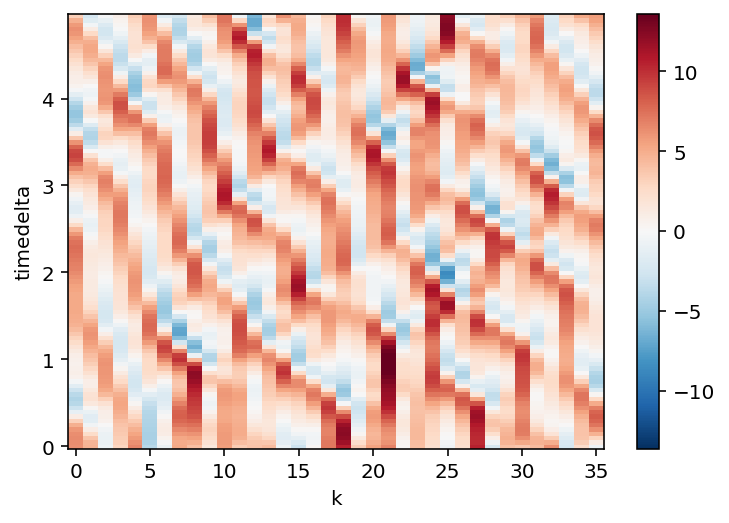

In [23]:
trajectory = unroll_model(l96_model, 100, {'slow': {'x': k}}, 25)
trajectory['slow']['x'].to_xarray().plot.imshow(x='k', y='timedelta')

We can also query Y variables

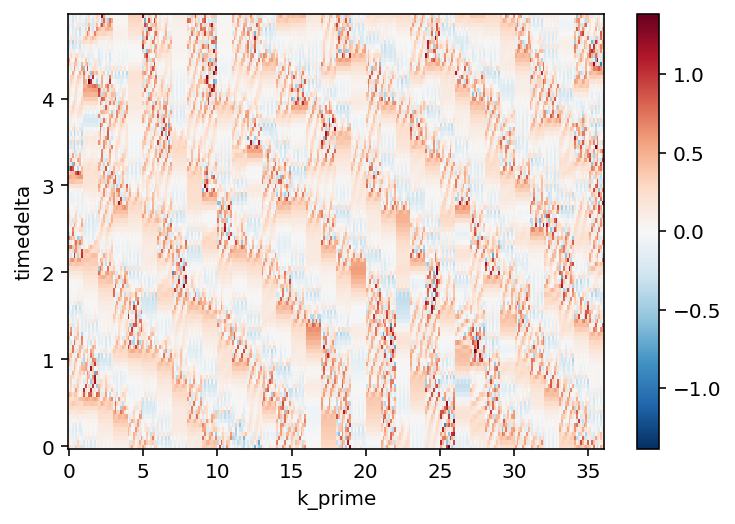

In [24]:
trajectory = unroll_model(l96_model, 100, {'fast': {'y': kj}}, 25)
fast_ds = trajectory['fast']['y'].to_xarray().stack(k_prime=('k', 'j'))
fast_ds.coords['k_prime'] = np.linspace(0, k.shape[0], fast_ds.sizes['k_prime'])
fast_ds.plot.imshow(x='k_prime', y='timedelta')

### Working in lower level functional API using `nnx.split`

For maximum control over the computation and removing the tiny amount of overhead that comes with `nnx` wrappers it can be beneficial to drop into "functional mode".

To do that `nnx` provides `nnx.split` and `nnx.merge` methods. For more details see [nnx-functional-api](https://flax.readthedocs.io/en/latest/nnx_basics.html#the-flax-functional-api)

Since `Model` is an `nnx.Module`, we can use this machinary to enable working with `jax` transformations on parts of the state. As a basic example, we will calculate the gradient of the mean state with respect to the `h` parameter. This same approach applies to neural network parameters, which will be covered in a later tutorial.

In [25]:
# Define a function to compute the mean of the 'x' variable

# Split the model into graph and state.
graph, model_params, other_state = nnx.split(l96_model, nnx.Param, ...)

def loss_fn(model_params):
  # Merge the graph and state to create a local model instance for computation.
  model = nnx.merge(graph, model_params, other_state, copy=True)
  model.advance()
  return jnp.mean(model.observe({'slow': {'x': k}})['slow']['x'].data)


grad_fn = jax.grad(loss_fn)
grads = grad_fn(model_params)
print(f'Gradient of mean(x) with respect to params: {grads}')

Gradient of mean(x) with respect to params: State({
  'h': Param( # 1 (4 B)
    value=Array(-0.00282221, dtype=float32, weak_type=True)
  )
})


## Observation operators and model queries

**Key conepts:**
* Observation operators compute predictions from prognostics to answer a user `query`
* The model query and nested data are partitioned by an observation operator key
* Query may contain dynamic information about the query details


Observation operators are routinely used to build connections between simulation variables and measured data. The computation associated with this transformation is performed as a part of `model.observe` method, where queries are dispatched to observation operators.

First, let's take a look at `ObservationOperator` interface and some examples:

Observation operators are `nnx.Module` instances, which allows them to hold trainable parameters and other modules that could be shared among different parts of the model.

```python
class ObservationOperator(nnx.Module, abc.ABC):

  @abc.abstractmethod
  def observe(
      self,
      inputs: dict[str, cx.Field],
      query: dict[str, cx.Field | cx.Coordinate],
  ) -> dict[str, cx.Field]:
    """Returns observations for `query`."""
    ...
```

The `observe` method computes observations associated with the `query` using `inputs` and `query` itself. In most cases `inputs` are a set of prognostic fields associated with the model that holds the observation operator, but could be other outputs as well.

Lets take a look at two simple operators:
* `DataObservationOperator`
* `TransformObservationOperator`

DataObservationOperator accepts a set of predictions at init and matches them with query, ignoring `inputs` argument.

In [26]:
# DataObservationOperator example.

x = cx.SizedAxis('x', 5)
precomputed_predictions = {'u': cx.wrap(np.arange(5), x), 't': cx.wrap(0.0)}
obs_op = observation_operators.DataObservationOperator(precomputed_predictions)
ignored_inputs = {}
print(obs_op.observe(ignored_inputs, {'u': x}))
print(obs_op.observe(ignored_inputs, {'t': cx.Scalar()}))

with print_error():
 obs_op.observe(ignored_inputs, {'v': x})

{'u': <Field dims=('x',) shape=(5,) axes={'x': SizedAxis} >}
{'t': <Field dims=() shape=() axes={} >}
ValueError: query contains k='v' not in ['u', 't']


TransformObservationOperator applies a user-specified `transform` to provided `inputs` and uses the values to match the query.

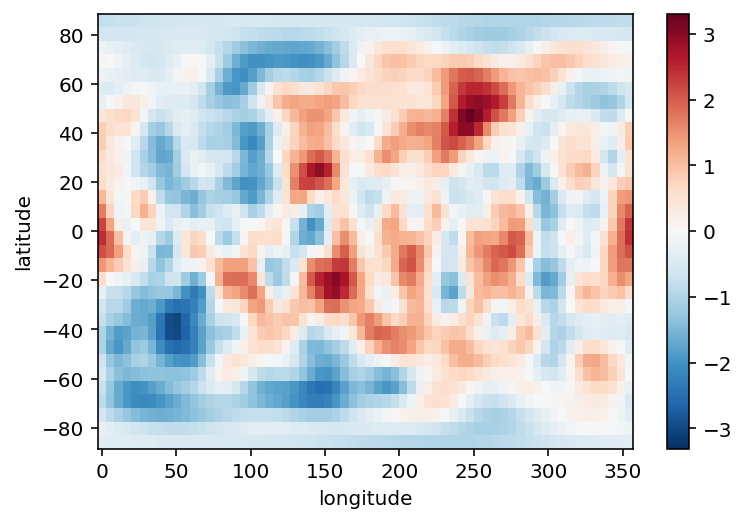

In [27]:
# TransformObservationOperator example.

# for this example we will use lon-lat and spherical harmonic coordinates on the
# sphere, frequently used in atmospheric simulations.
grid = coordinates.LonLatGrid.T21()
ylm_grid = coordinates.SphericalHarmonicGrid.T21()

rng = np.random.RandomState(4)
l, m = ylm_grid.total_wavenumbers, 2 * ylm_grid.longitude_wavenumbers
u_modal = rng.normal(size=(m, l)) * np.exp(-4 * np.arange(l) / l)[None, :]
modal_inputs = {'u': cx.wrap(u_modal, ylm_grid)}

ylm_transform = spherical_transforms.YlmMapper(partition_schema_key=None, mesh=parallelism.Mesh())
to_nodal_transform = transforms.ToNodal(ylm_transform)

obs_op = observation_operators.TransformObservationOperator(to_nodal_transform)

observation = obs_op.observe(modal_inputs, {'u': grid})
observation['u'].to_xarray().plot(x='longitude', y='latitude')

Users can use `TransformObservationOperator` with trainable transformations (e.g. transforms parameterized by neural networks) or implement their own `ObservationOperator` classes to suit their needs. By using custom parameter types or tags it is then possible to isolate gradients with respect to parameters of observation operators for fine-tuning tasks without affecting the rest of the model.

### Dispatching of model query and model query structure

Since `Model` can hold numerous observation operators, it needs a mechanism to dispatch a full query to individual components.

This dispatch process is based on key matching between the model query and observation operators. Namely `Model` requires the following structure of operators and model query:
`OperatorKey = str`
* `model_query: dict[OperatorKey: dict[str, cx.Field | cx.Coordinate]]`
* `operators: dict[OperatorKey: ObservationOperator]`

This mirrors the model input data structure, which is `dict[ObservationSource, dict[str, cx.Field]]`, where `ObservationSource` string is the same as `OperatorKey`.

This approach aims at simplicity at the cost of slight configuration overhead that might be encountered in cases when:
1. multiple operators required to cover data from a single source
2. multiple sources are associated with the same observation operator

These cases can be addressed by a combination of renaming and multiple references to the same observation operator/transform. These will be covered in one of the advanced tutorials.

### Adding observation operator to our Lorenz model

To complete the intro to observation operators and queries, let us add an observation operator that looks at particular value of the state (mimicing a point measurement)

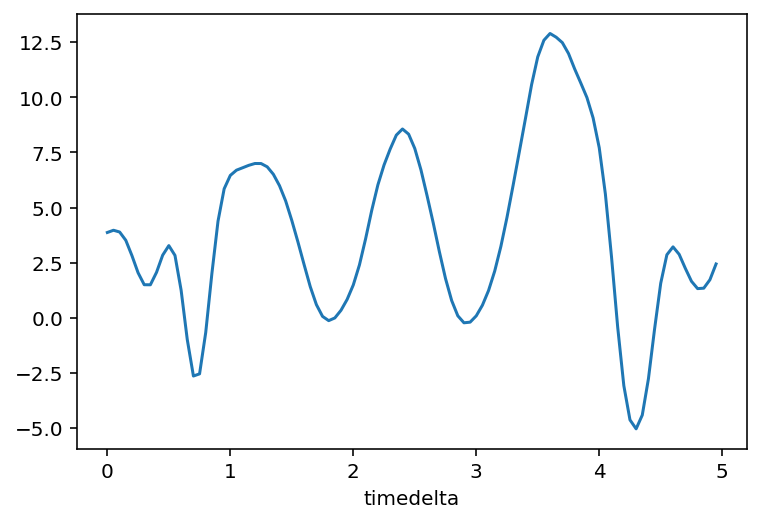

In [28]:
sel_point = transforms.Sel({'k': 4})  # will select k == 4 from the X field.
point_obs = observation_operators.TransformObservationOperator(sel_point)
l96_model.operators['k=4'] = point_obs
k4_trajectory = unroll_model(l96_model, 100, {'k=4': {'x': cx.Scalar()}}, 25)
k4_trajectory['k=4']['x'].to_xarray().plot(x='timedelta')